<a href="https://colab.research.google.com/github/AF-mygithub/AI-Agent/blob/main/Andy_Feng_NVIDIA_AI_Agent_Developer_Contest__Integration_of_Image_Description_and_Object_Detection__(Final_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Development: AI Agent for Image Description
I will commence by building an AI agent specialized in providing detailed and accurate image descriptions.

# Subsequent Enhancement: Integration of Image Description and Object Detection
Following this, I will enhance the AI agent by integrating advanced object detection capabilities. This subsequent enhancement will create a dual-functionality system that excels in both image description and object identification, significantly enhancing the agent's overall performance and versatility.

# Result: Versatile AI Agent
The resulting AI agent will possess the dual capabilities of image description and object detection, rendering it highly effective for critical applications such as military operations and autonomous driving systems. This advancement is expected to have profound impacts, including improved situational awareness, increased operational efficiency, and enhanced safety in demanding and high-risk environments.
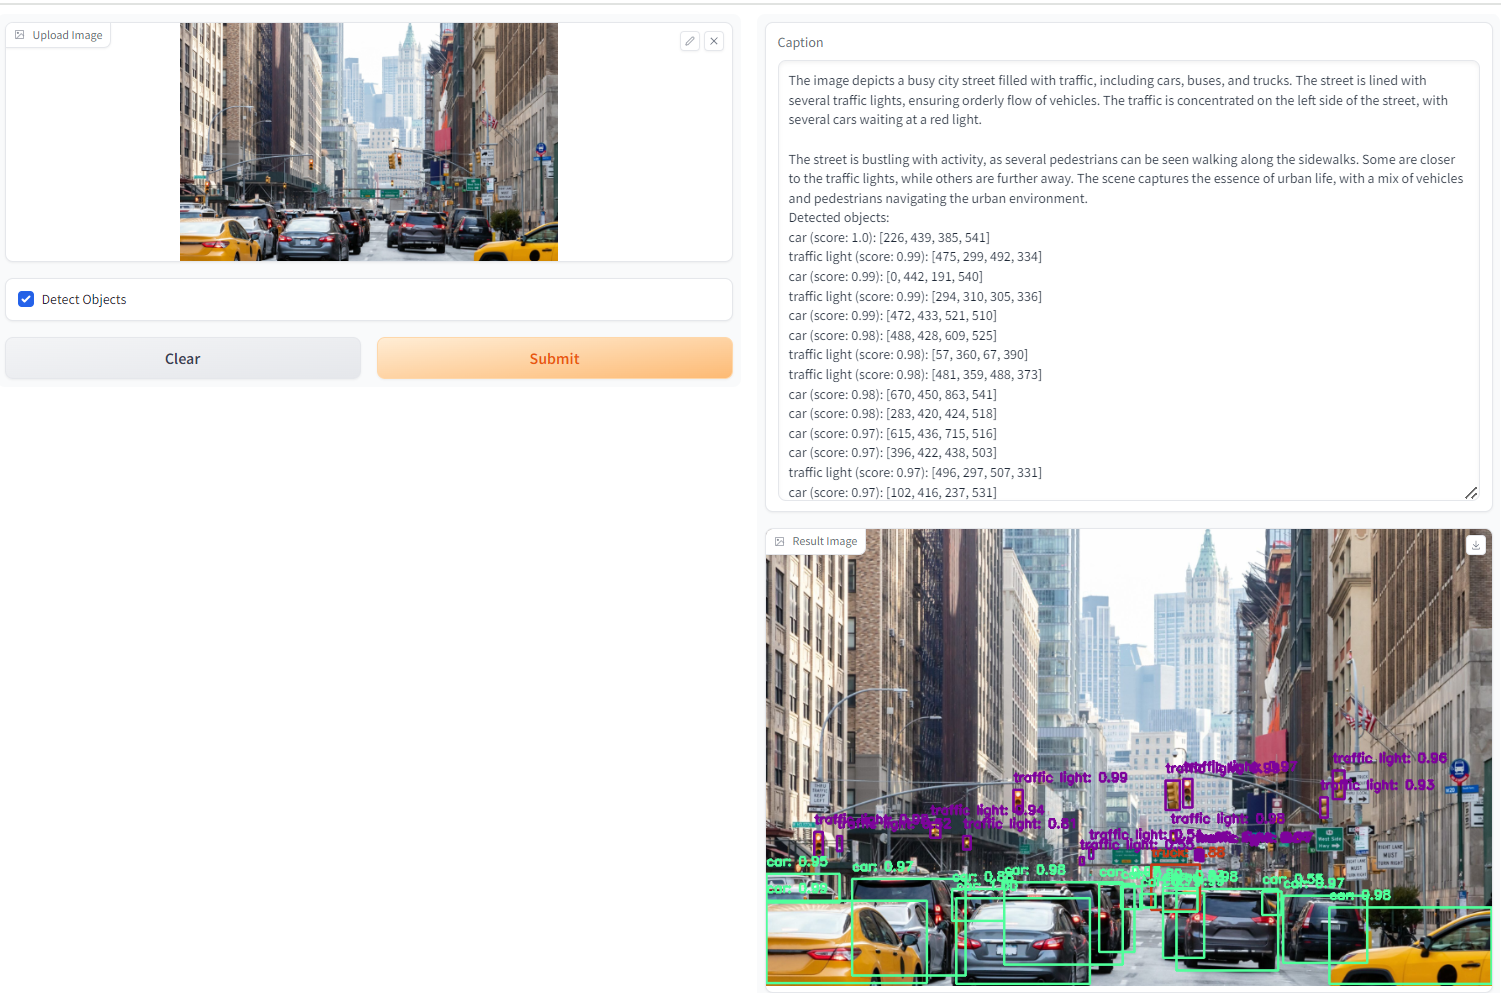




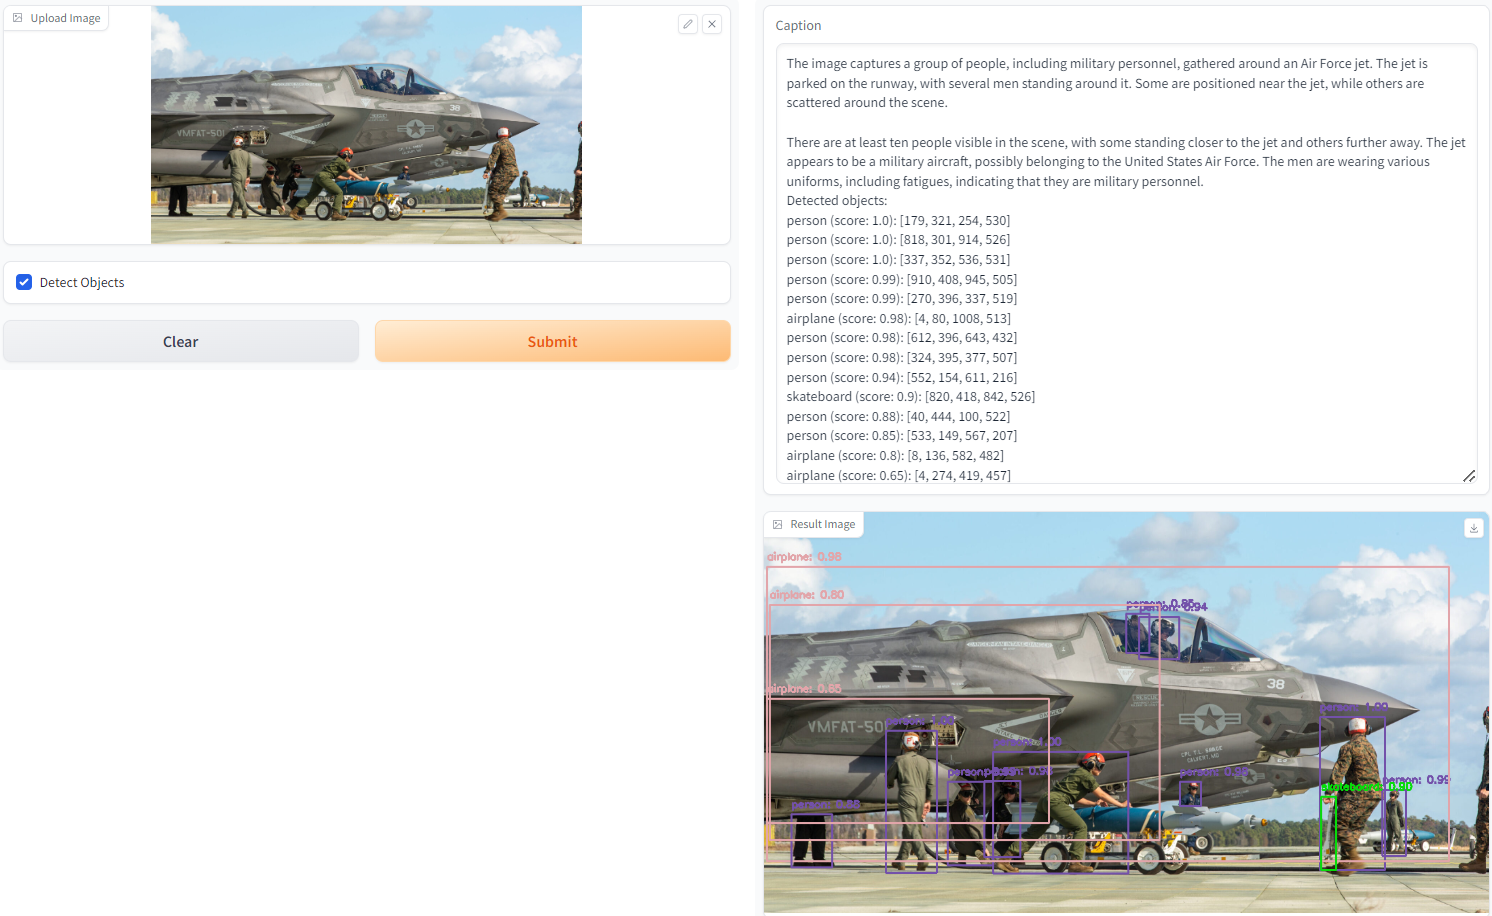

## Part 1. Initial Development: AI Agent for Image Description

In [ ]:
import getpass
import os

# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key
global nvapi_key

NVAPI Key (starts with nvapi-): ··········


In [ ]:
# Install libraries
!pip install gradio==3.48.0
!pip install openai
!pip install langchain
!pip install langchain-nvidia-ai-endpoints

In [ ]:
# Import libraries
import getpass
import os
import openai, httpx, sys
import base64, io
from PIL import Image
import requests, json
from google.colab import files

# Define function to fetch streaming outputs
def fetch_streaming_outputs(output):
    collected_outputs = []
    for o in output:
        try:
            start = o.index('{')
            json_string = o[start:]
            data = json.loads(json_string)
            content = data['choices'][0]['delta']['content']
            collected_outputs.append(content)
        except:
            pass
    return ''.join(collected_outputs).replace('\\', '').replace('\'', '')

# Define function to convert image to base64 string
def image_to_base64(image_path):
    image = Image.open(image_path)
    if image.width > 800 or image.height > 800:
        image.thumbnail((800, 800))
    buffered = io.BytesIO()
    image.convert("RGB").save(buffered, format="JPEG", quality=85)
    image_base64 = base64.b64encode(buffered.getvalue()).decode()
    return image_base64

# Define function to get the NVAPI key
def get_nvapi_key():
    if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
        return os.environ["NVIDIA_API_KEY"]
    else:
        nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
        assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
        os.environ["NVIDIA_API_KEY"] = nvapi_key
        return nvapi_key

# Define function to call Fuyu API and generate text
def generate_text(prompt, image_path):
    invoke_url = "https://ai.api.nvidia.com/v1/vlm/adept/fuyu-8b"
    stream = True

    image_b64 = image_to_base64(image_path)
    assert len(image_b64) < 200_000, "Image is too large. Use the assets API for larger images."

    headers = {
        "Authorization": f"Bearer {get_nvapi_key()}",
        "Accept": "text/event-stream" if stream else "application/json"
    }

    payload = {
        "messages": [
            {
                "role": "user",
                "content": f'{prompt} <img src="data:image/png;base64,{image_b64}" />'
            }
        ],
        "max_tokens": 1024,
        "temperature": 0.20,
        "top_p": 0.70,
        "seed": 0,
        "stream": stream
    }

    response = requests.post(invoke_url, headers=headers, json=payload)

    if stream:
        output = []
        for line in response.iter_lines():
            if line:
                output.append(line.decode("utf-8"))
    else:
        output = response.json()
    return fetch_streaming_outputs(output)

# Prompt the user to upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
filename = next(iter(uploaded))

# Construct the full path to the uploaded file
# Colab saves uploaded files to the content folder
image_path = '/content/' + filename

# Set the prompt
prompt = "Describe the image:"

# Generate the text from the image and prompt
out = generate_text(prompt, image_path)

# Print the generated text
print(out)

Saving F-35.png to F-35.png
The image captures a group of people, including military personnel, gathered around an Air Force jet. The jet is parked on the runway, with several men standing around it. Some are positioned near the jet, while others are scattered around the scene.

There are at least ten people visible in the scene, with some standing closer to the jet and others further away. The jet appears to be a military aircraft, possibly belonging to the United States Air Force. The men are wearing various uniforms, including fatigues, indicating that they are military personnel.


In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
nvapi_key = get_nvapi_key()
llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1", nvidia_api_key=nvapi_key, max_tokens=1024)

In [ ]:
import os
import io
import json
import base64
import requests
import torch
import gradio as gr
from PIL import Image
from tempfile import NamedTemporaryFile
from langchain.tools import BaseTool
from transformers import BlipProcessor, BlipForConditionalGeneration, DetrImageProcessor, DetrForObjectDetection
from langchain.agents import initialize_agent
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

def encode_image_to_base64(image_path):
    """Convert an image to a base64-encoded string."""
    with Image.open(image_path) as image:
        if image.width > 800 or image.height > 800:
            image.thumbnail((800, 800))
        buffered = io.BytesIO()
        image.convert("RGB").save(buffered, format="JPEG", quality=85)
        return base64.b64encode(buffered.getvalue()).decode()

def parse_response_stream(response_stream):
    """Parse the response stream to extract relevant content."""
    collected_content = []
    for line in response_stream:
        try:
            start_idx = line.index('{')
            json_string = line[start_idx:]
            response_data = json.loads(json_string)
            content_piece = response_data['choices'][0]['delta']['content']
            collected_content.append(content_piece)
        except (ValueError, json.JSONDecodeError):
            continue
    return ''.join(collected_content).replace('\\', '').replace('\'', '')

class ImageCaptioningTool(BaseTool):
    """Tool for generating descriptive captions for images using NVIDIA's Fuyu model."""

    name = "Image Captioning Tool"
    description = "Generates descriptive captions for provided images."

    def _run(self, image_path):
        invoke_url = "https://ai.api.nvidia.com/v1/vlm/adept/fuyu-8b"
        image_base64 = encode_image_to_base64(image_path)

        assert len(image_base64) < 200_000, "For larger images, please use the assets API."

        headers = {
            "Authorization": f"Bearer {nvapi_key}",
            "Accept": "text/event-stream"
        }

        payload = {
            "messages": [
                {
                    "role": "user",
                    "content": f'Describe the contents of this image: <img src="data:image/png;base64,{image_base64}" />'
                }
            ],
            "max_tokens": 1024,
            "temperature": 0.20,
            "top_p": 0.70,
            "seed": 0,
            "stream": True
        }

        response = requests.post(invoke_url, headers=headers, json=payload)
        response_content = parse_response_stream(response.iter_lines())
        return response_content

    def _arun(self, query: str):
        raise NotImplementedError("Async functionality is not supported for this tool.")

class ChartDataExtractionTool(BaseTool):
    """Tool for extracting underlying data from images containing charts."""

    name = "Chart Data Extraction Tool"
    description = "Extracts and returns underlying data from images of charts."

    def _run(self, image_path):
        invoke_url = "https://ai.api.nvidia.com/v1/vlm/google/deplot"
        image_base64 = encode_image_to_base64(image_path)

        assert len(image_base64) < 180_000, "For larger images, please use the assets API."

        headers = {
            "Authorization": f"Bearer {nvapi_key}",
            "Accept": "text/event-stream"
        }

        payload = {
            "messages": [
                {
                    "role": "user",
                    "content": f'Generate the data table for this figure: <img src="data:image/png;base64,{image_base64}" />'
                }
            ],
            "max_tokens": 1024,
            "temperature": 0.20,
            "top_p": 0.20,
            "stream": True
        }

        response = requests.post(invoke_url, headers=headers, json=payload)
        response_content = parse_response_stream(response.iter_lines())
        return response_content

    def _arun(self, query: str):
        raise NotImplementedError("Async functionality is not supported for this tool.")


In [ ]:
# Initialize the advanced tools for image captioning and chart data extraction
tools = [
    ImageCaptioningTool(),
    ChartDataExtractionTool()
]

# Configure conversational memory with a buffer window to retain chat history
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

# Initialize the high-performance agent with advanced conversational capabilities
agent = initialize_agent(
    agent="chat-conversational-react-description",
    tools=tools,
    llm=llm,
    max_iterations=5,
    verbose=True,
    memory=conversational_memory,
    handle_parsing_errors=True,
    early_stopping_method='generate'
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
def parse_response_stream(response_stream):
    """Parse the response stream to extract relevant content."""
    collected_content = []
    for line in response_stream:
        # Decode the line from bytes to string if necessary
        if isinstance(line, bytes):
            line = line.decode('utf-8')
        try:
            start_idx = line.index('{')
            json_string = line[start_idx:]
            response_data = json.loads(json_string)
            content_piece = response_data['choices'][0]['delta']['content']
            collected_content.append(content_piece)
        except (ValueError, json.JSONDecodeError):
            continue
    return ''.join(collected_content).replace('\\', '').replace('\'', '')

def extract_content_from_stream(response_stream):
    """Extract meaningful content from the response stream."""
    content_accumulator = []
    for line in response_stream:
        # Decode the line from bytes to string
        decoded_line = line.decode('utf-8')
        try:
            start_index = decoded_line.index('{')
            json_str = decoded_line[start_index:]
            parsed_json = json.loads(json_str)
            content_fragment = parsed_json['choices'][0]['delta']['content']
            content_accumulator.append(content_fragment)
        except (ValueError, json.JSONDecodeError):
            continue
    return ''.join(content_accumulator).replace('\\', '').replace('\'', '')

# Invoke the agent with the provided image path
response = agent.invoke({
    "input": f"This is the image path: {image_path}"
})

# Output the response from the agent
print(response['output'])

def call_agent_with_image(image_path):
    """Call the agent with a specified image path and return the output."""
    response = agent.invoke({
        "input": f"This is the image path: {image_path}"
    })
    return response['output']



> Entering new AgentExecutor chain...
 ```json
{
    "action": "Image Captioning Tool",
    "action_input": "/content/F-35.png"
}
```
Observation: The image features a large military jet parked on an airport runway. The jet is grey and prominently displayed, drawing attention to it. Several military personnel are scattered around the jet, likely performing their duties or preparing for a mission.

In addition to the people, there are various vehicles, including cars and trucks, parked in the vicinity. These vehicles appear to be associated with the jets operations, possibly for loading, refueling, or transporting equipment. The scene captures the busy atmosphere of a military airbase, with personnel and vehicles working together to ensure the jets readiness for flight.
Thought: ```json
{
    "action": "Final Answer",
    "action_input": "The image depicts a large grey military jet parked on an airport runway, surrounded by military personnel and vehicles. This suggests that the jet i

In [ ]:
import gradio as gr

# Define the Gradio interface for the image captioning application
ImageCaptionApp = gr.Interface(
    fn=call_agent_with_image,
    inputs=[gr.Image(label="Upload Image", type="filepath")],
    outputs=[gr.Textbox(label="Caption")],
    title="Image Captioning with AI Agent",
    description="Combine AI agent using advanced tools for image reasoning",
    allow_flagging="never"
)

# Launch the application with sharing enabled
ImageCaptionApp.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://ce4dd2316e0e3d4a06.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Part 2. Subsequent Enhancement: Integration of Image Description and Object Detection


In [ ]:
!pip install transformers gradio torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
from PIL import Image
import cv2
import numpy as np
import gradio as gr
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import requests
import base64
import json
import os
from getpass import getpass
import io

# Load models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn_model.eval()

# Define COCO (Common Objects in Context) classes:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
    'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Function to convert image to base64 string
def image_to_base64(image_path):
    image = Image.open(image_path)
    if image.width > 800 or image.height > 800:
        image.thumbnail((800, 800))
    buffered = io.BytesIO()
    image.convert("RGB").save(buffered, format="JPEG", quality=85)
    image_base64 = base64.b64encode(buffered.getvalue()).decode()
    return image_base64

# Function to get the NVAPI key
def get_nvapi_key():
    if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
        return os.environ["NVIDIA_API_KEY"]
    else:
        nvapi_key = getpass("NVAPI Key (starts with nvapi-): ")
        assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
        os.environ["NVIDIA_API_KEY"] = nvapi_key
        return nvapi_key

# Function to call Fuyu API and generate text
def generate_text(prompt, image_path):
    invoke_url = "https://ai.api.nvidia.com/v1/vlm/adept/fuyu-8b"
    stream = True

    image_b64 = image_to_base64(image_path)
    assert len(image_b64) < 200_000, "Image is too large. Use the assets API for larger images."

    headers = {
        "Authorization": f"Bearer {get_nvapi_key()}",
        "Accept": "text/event-stream" if stream else "application/json"
    }

    payload = {
        "messages": [
            {
                "role": "user",
                "content": f'{prompt} <img src="data:image/png;base64,{image_b64}" />'
            }
        ],
        "max_tokens": 1024,
        "temperature": 0.20,
        "top_p": 0.70,
        "seed": 0,
        "stream": stream
    }

    response = requests.post(invoke_url, headers=headers, json=payload)

    if stream:
        output = []
        for line in response.iter_lines():
            if line:
                output.append(line.decode("utf-8"))
    else:
        output = response.json()
    return fetch_streaming_outputs(output)

# Function to fetch streaming outputs
def fetch_streaming_outputs(output):
    collected_outputs = []
    for o in output:
        try:
            start = o.index('{')
            json_string = o[start:]
            data = json.loads(json_string)
            content = data['choices'][0]['delta']['content']
            collected_outputs.append(content)
        except:
            pass
    return ''.join(collected_outputs).replace('\\', '').replace('\'', '')

# Function to detect objects using Faster R-CNN
def detect_objects(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = fasterrcnn_model(image_tensor)

    detected_objects = []
    output = outputs[0]
    for idx, box in enumerate(output['boxes']):
        score = output['scores'][idx].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[output['labels'][idx].item()]
        if score >= 0.5:
            detected_objects.append({
                "score": round(score, 2),
                "label": label,
                "bounding_box": [int(b) for b in box.tolist()]
            })

    image_cv2 = cv2.imread(image_path)
    colors = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))
    for obj in detected_objects:
        box = obj['bounding_box']
        label = obj['label']
        color = colors[COCO_INSTANCE_CATEGORY_NAMES.index(label)]
        cv2.rectangle(image_cv2, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.putText(image_cv2, f"{label}: {obj['score']:.2f}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    result_image_path = "result_image.png"
    cv2.imwrite(result_image_path, image_cv2)

    return detected_objects, result_image_path

# Function to call the agent with image and objects
def call_agent_with_image_and_objects(image_path, detect_objects_flag):
    nvapi_key = get_nvapi_key()  # Use the function from Part 1 to get the NVAPI key

    print(f"Detect Objects Flag: {detect_objects_flag}")
    print(f"Image Path: {image_path}")
    print(f"NVIDIA API Key: {nvapi_key}")

    if detect_objects_flag:
        detected_objects, result_image_path = detect_objects(image_path)
        formatted_objects = "\n".join([f"{obj['label']} (score: {obj['score']}): {obj['bounding_box']}" for obj in detected_objects])
        description = generate_text("Describe the image:", image_path)
        description += f"\nDetected objects:\n{formatted_objects}"
    else:
        description = generate_text("Describe the image:", image_path)
        result_image_path = image_path

    print(f"Description: {description}")
    print(f"Result Image Path: {result_image_path}")

    return description, result_image_path

# Define the Gradio interface for the image captioning application
ImageCaptionApp = gr.Interface(
    fn=call_agent_with_image_and_objects,
    inputs=[
        gr.Image(label="Upload Image", type="filepath"),
        gr.Checkbox(label="Detect Objects")
    ],
    outputs=[gr.Textbox(label="Caption"), gr.Image(label="Result Image")],
    title="Image Captioning with AI Agent",
    description="Combine AI agent using advanced tools for image reasoning",
    allow_flagging="never"
)

# Launch the application with sharing enabled
ImageCaptionApp.launch(share=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://67622c4672f5d84c61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## The above cell illustrates the Result: Versatile AI Agent.
The resulting AI agent will possess the dual capabilities of image description and object detection, rendering it highly effective for critical applications such as military operations and autonomous driving systems. This advancement is expected to have profound impacts, including improved situational awareness, increased operational efficiency, and enhanced safety in demanding and high-risk environments.